In [1]:
import pandas as pd
from pathlib import Path

# data/processed is one level up from notebooks/
DATA_PROCESSED_DIR = Path("..") / "data" / "processed"

# Load raw pieces
deaths = pd.read_parquet(DATA_PROCESSED_DIR / "vital_stats_deaths_2006_2015.parquet")
pop = pd.read_parquet(DATA_PROCESSED_DIR / "us_population_condensed_2006_2015.parquet")
arcos = pd.read_parquet(DATA_PROCESSED_DIR / "arcos_county_year_with_fips.parquet")

# Make sure FIPS is 5-char string
for df in (deaths, pop, arcos):
    df["fips"] = df["fips"].astype(str).str.zfill(5)

# Merge into raw panel (no imputation, no dropping)
panel = pop.merge(
    deaths[["fips", "year", "drug_deaths"]],
    on=["fips", "year"],
    how="left",
)

panel = panel.merge(
    arcos[["fips", "year", "opioid_shipments_mme", "total_pills"]],
    on=["fips", "year"],
    how="left",
)

print("Panel shape:", panel.shape)
panel.head()

Panel shape: (31404, 9)


,year,fips,state_abbrev,state_fips,county_code,population,drug_deaths,opioid_shipments_mme,total_pills
0,2006,01001,AL,01,001,51328,NaN,37470788.0,2813276.0
1,2007,01001,AL,01,001,52405,NaN,41902204.0,3136904.0
2,2008,01001,AL,01,001,53277,NaN,46244220.0,3416871.0
3,2009,01001,AL,01,001,54135,NaN,52270700.0,3725218.0
4,2010,01001,AL,01,001,54792,NaN,56967840.0,3809211.0


In [2]:
# 1. Mark suppressed values
panel["is_suppressed"] = panel["drug_deaths"].isna().astype(int)

# 2. Suppression rate per county
supp_rate = (
    panel.groupby("fips")["is_suppressed"]
    .mean()
    .reset_index()
    .rename(columns={"is_suppressed": "suppression_rate"})
)

# 3. Median population per county
median_pop = (
    panel.groupby("fips")["population"]
    .median()
    .reset_index()
    .rename(columns={"population": "median_population"})
)

# 4. Merge for plotting
county_summary = supp_rate.merge(median_pop, on="fips")

county_summary.head(), county_summary.shape

(    fips  suppression_rate  median_population
 0  01001               1.0            55149.0
 1  01003               0.0           185151.5
 2  01005               1.0            27383.0
 3  01007               1.0            22607.5
 4  01009               0.5            57554.5,
 (3145, 3))

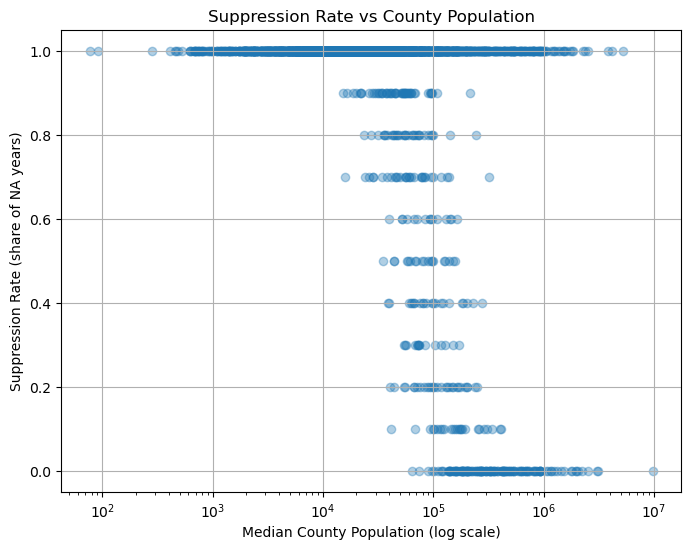

In [3]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))

plt.scatter(
    county_summary["median_population"], county_summary["suppression_rate"], alpha=0.35
)

plt.xscale("log")
plt.xlabel("Median County Population (log scale)")
plt.ylabel("Suppression Rate (share of NA years)")
plt.title("Suppression Rate vs County Population")
plt.grid(True)
plt.show()

In [4]:
#  proposed cutoffs
POP_CUTOFF = 50000
SUPPR_CUTOFF = 0.40

# Step 1: Identify counties that pass the combined rule
good_counties = county_summary[
    (county_summary["median_population"] >= POP_CUTOFF)
    & (county_summary["suppression_rate"] <= SUPPR_CUTOFF)
]["fips"]

# Step 2: Total number of suppressed values in the entire panel
total_suppressed = panel["drug_deaths"].isna().sum()

# Step 3: Suppressed values ONLY in the kept (good) counties
remaining_suppressed = (
    panel[panel["fips"].isin(good_counties)]["drug_deaths"].isna().sum()
)

# Step 4: Percentage that remain
pct_remaining = remaining_suppressed / total_suppressed * 100

total_suppressed, remaining_suppressed, pct_remaining

(np.int64(28838), np.int64(203), np.float64(0.7039323115333934))

To ensure counties had enough observable mortality data for trend analysis, we examined the relationship between population size and the frequency of CDC-suppressed drug death counts (NAs). A clear elbow appeared in the suppression–population plot: counties below ~50,000 population showed consistently high suppression, while larger counties rarely had missing values.
We applied two data-driven filters:
Population ≥ 50,000
Suppression rate ≤ 40% (suppressed in no more than 40% of years)
Counties were kept only if they met both conditions.
This reduced the number of suppressed values from 28,838 to 203, meaning only ~0.7% of suppressed values remain for imputation. This creates a cleaner, more reliable analysis panel while minimizing imputation.